### Predict annual insurance premium in USD based on demographic and lifestyle features to support automated pricing decisions.

Insurance Dataset for Predicting Health Insurance Premiums in the US is a collection of data on various factors that can influence medical costs and premiums for health insurance in the United States. The dataset includes information on 10 variables, including age, gender, body mass index (BMI), number of children, smoking status, region, occupation, type of insurance plan etc.
There are 1 million records in this dataset.
You can use the first 700k records for building the model, 200k records for evaluating the model and the rest of the records as live records on which model would be evaluated in production.


#### Data Loading

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("regression.db")
df = pd.read_sql("SELECT * FROM Insurance_Prediction", conn)
conn.close()


In [2]:
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46.0,male,21.45,5.0,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25.0,female,25.38,2.0,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38.0,male,44.88,2.0,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25.0,male,19.89,0.0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49.0,male,38.21,3.0,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [3]:
df.shape

(1000000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     960000 non-null   float64
 1   gender                  976000 non-null   object 
 2   bmi                     1000000 non-null  float64
 3   children                968000 non-null   float64
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              968000 non-null   object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(4), object(8)
memory usage: 91.6+ MB


#### Creating the train and test split

In [5]:
train = df.iloc[:700000].reset_index(drop=True)
val   = df.iloc[700000:900000].reset_index(drop=True)
prod  = df.iloc[900000:].reset_index(drop=True)

print(train.shape, val.shape, prod.shape)

(700000, 12) (200000, 12) (100000, 12)


In [6]:
train.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46.0,male,21.45,5.0,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25.0,female,25.38,2.0,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38.0,male,44.88,2.0,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25.0,male,19.89,0.0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49.0,male,38.21,3.0,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


#### Data Cleaning and EDA

##### Checking for null values

In [7]:
train.isnull().sum()

age                        27851
gender                     16850
bmi                            0
children                   22470
smoker                         0
region                         0
medical_history           175568
family_medical_history    175518
exercise_frequency             0
occupation                 22470
coverage_level                 0
charges                        0
dtype: int64

In [8]:
(train.isnull().sum()*100)/(len(train))

age                        3.978714
gender                     2.407143
bmi                        0.000000
children                   3.210000
smoker                     0.000000
region                     0.000000
medical_history           25.081143
family_medical_history    25.074000
exercise_frequency         0.000000
occupation                 3.210000
coverage_level             0.000000
charges                    0.000000
dtype: float64

We cannot drop any of the rows as even 4% of 700k = 28,000 rows lost, we will lose information for free, hence we will try to fill in the missing vlaues

In order to decide what we need to fill the missing data with, we need to perform the EDA and other operations

##### Separating numeric and categorical data 

In [9]:
num_col=train.select_dtypes(exclude=['object']).columns.tolist()
num_col

['age', 'bmi', 'children', 'charges']

In [10]:
cat_col=train.select_dtypes(include=['object']).columns.tolist()
cat_col

['gender',
 'smoker',
 'region',
 'medical_history',
 'family_medical_history',
 'exercise_frequency',
 'occupation',
 'coverage_level']

##### EDA on numeric data

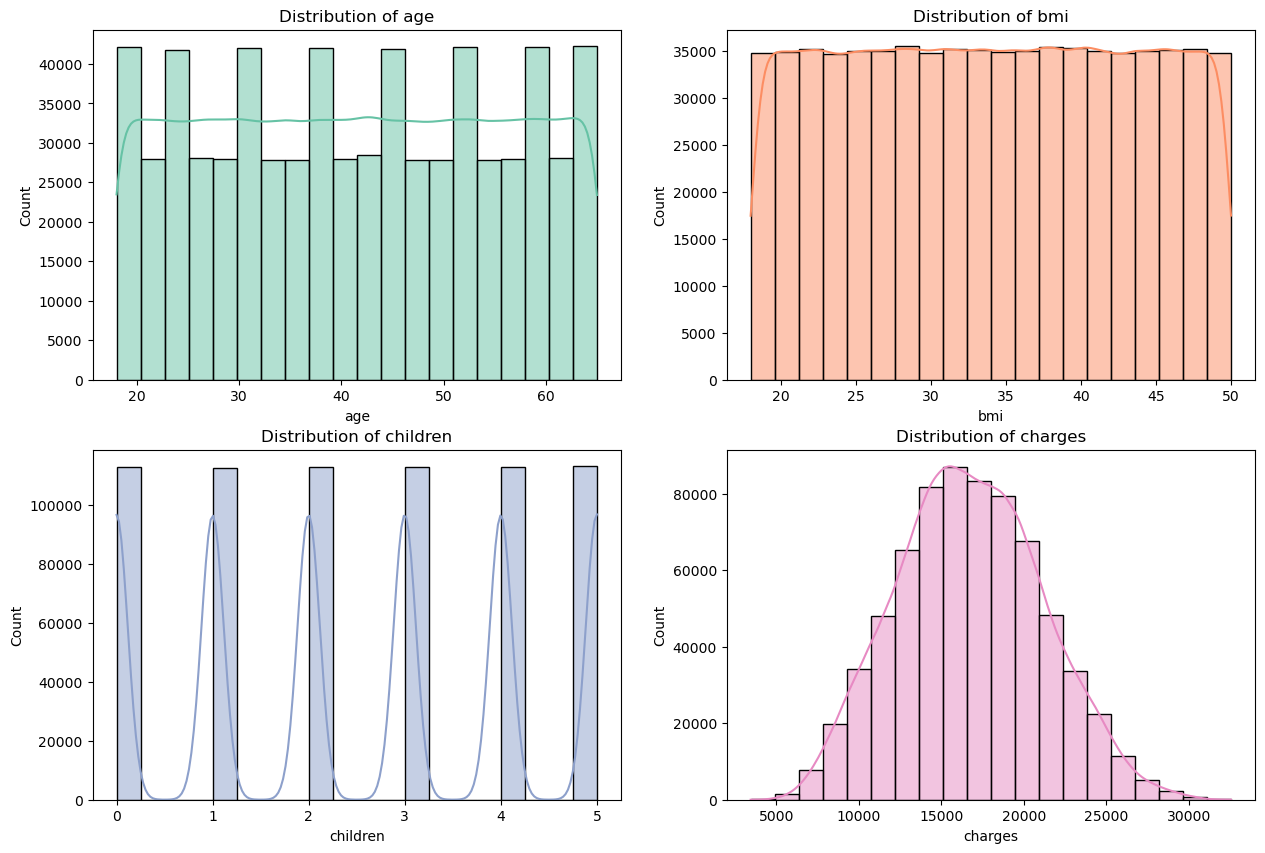

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for i, col in enumerate(num_col):
    plt.subplot(2,2, i+1)
    single_color=sns.color_palette("Set2")[i]
    sns.histplot(data=train, x=col, kde=True, bins=20, color=single_color)
    plt.title(f"Distribution of {col}")
#plt.tight_layout()
plt.show()   

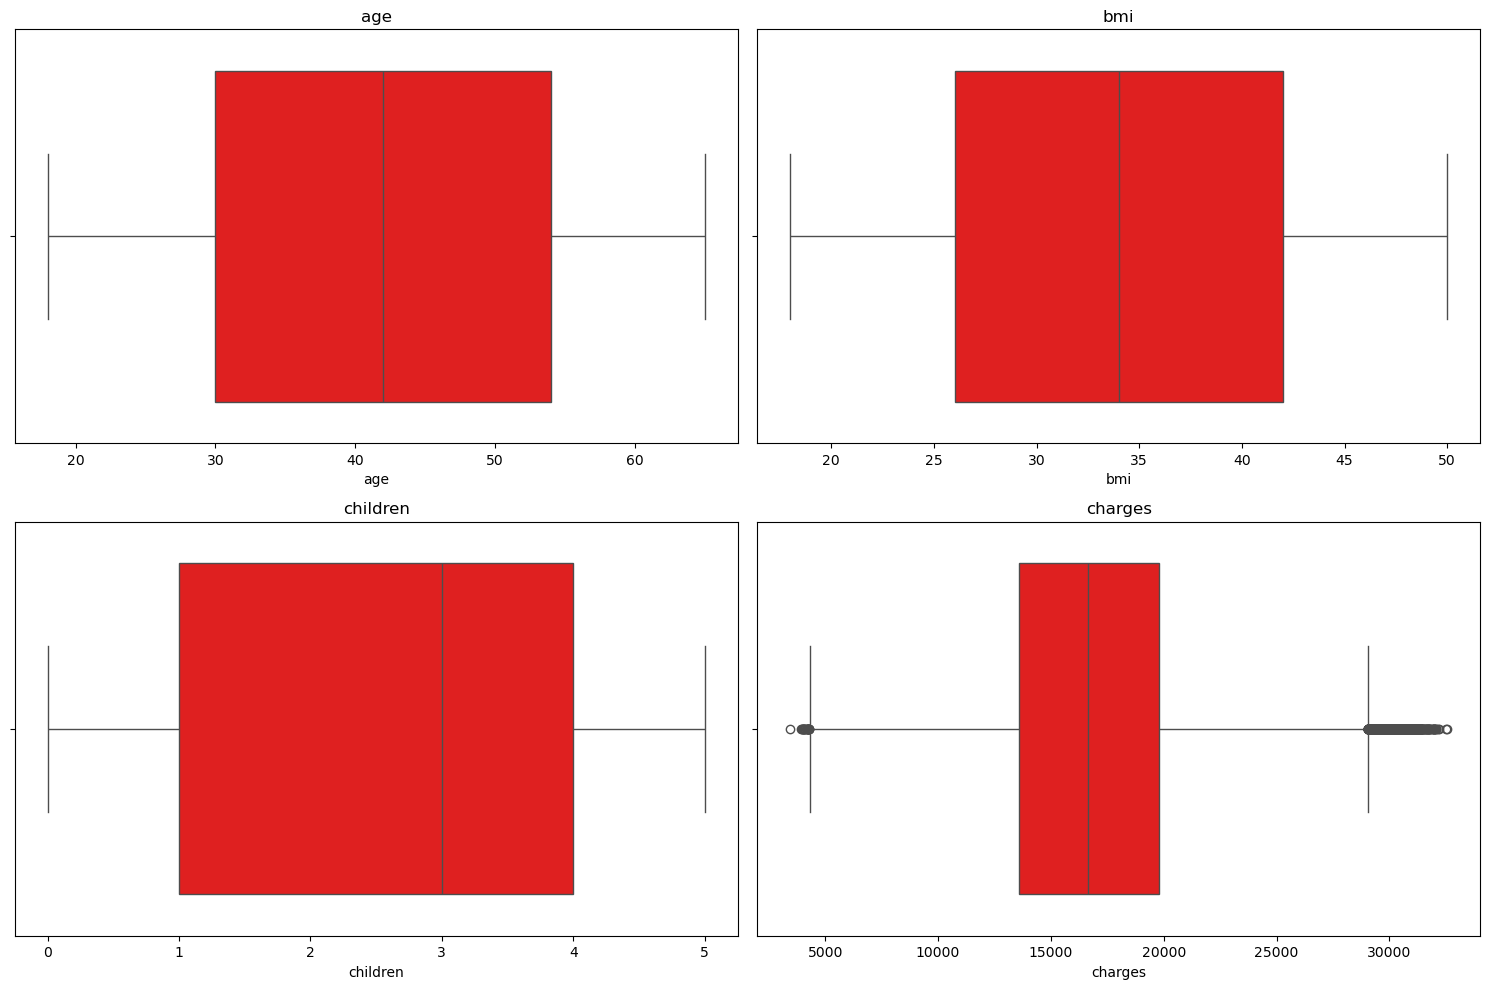

In [12]:
plt.figure(figsize=(15,10))
for i, col in enumerate(num_col):
   plt.subplot(2,2, i+1)
   sns.boxplot(data=train, x=col, color='red')
   plt.title(f'{col}')
plt.tight_layout()
plt.show()

##### Observations:
- Age -> uniformly distributed -> no outliers -> Mean~Median -> choosing Median for filling na values here
- Bmi -> uniformly distributed -> no outliers -> Mean~Median -> choosing Median for filling na values here **No null vlaues**
- children -> Discrete Data -> No outliers -> Median -> round -> int
- Charges -> Normal distribution -> Outliers presence -> choosing Median for filling na values here **No null values**
- Although outlier is present in the charges we will not drop it since it can be for rare disease scenarios premium might be high

In [13]:
#filling the value as median for age and children 
for i in ['age','children']:
    median_val=train[i].median()
    train[i]=train[i].fillna(median_val)
    
#rounding the values in column children
train['children']=train['children'].round()

#changing the data type to astype(Int64)
train['children']=train['children'].astype('Int64')

train.head()


,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46.0,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25.0,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38.0,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25.0,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49.0,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [14]:
#checking for the numeric null values after applying the changes
train.isnull().sum()

age                            0
gender                     16850
bmi                            0
children                       0
smoker                         0
region                         0
medical_history           175568
family_medical_history    175518
exercise_frequency             0
occupation                 22470
coverage_level                 0
charges                        0
dtype: int64

##### Golden Rule:
- Show raw missing counts
- Show raw nunique
- Show raw value_counts
- Explain imputation logic
- Apply imputation
- Show updated nunique
- Then encode

##### EDA categorical columns
EDA should be performed before imputation to understand the true distribution, balance, and missing patterns of the original data. Performing EDA only after imputation can hide the impact of artificially introduced categories and may misrepresent the real data structure.


In [15]:
for i in cat_col:
    print(train[i].value_counts()) #for percentage: normalize=True
    print("-"*50)

gender
male      341710
female    341440
Name: count, dtype: int64
--------------------------------------------------
smoker
yes    350095
no     349905
Name: count, dtype: int64
--------------------------------------------------
region
northeast    175303
northwest    175244
southwest    174766
southeast    174687
Name: count, dtype: int64
--------------------------------------------------
medical_history
Heart disease          175228
High blood pressure    174721
Diabetes               174483
Name: count, dtype: int64
--------------------------------------------------
family_medical_history
Heart disease          175096
High blood pressure    174827
Diabetes               174559
Name: count, dtype: int64
--------------------------------------------------
exercise_frequency
Rarely          175273
Occasionally    175213
Frequently      175107
Never           174407
Name: count, dtype: int64
--------------------------------------------------
occupation
Unemployed      170010
Blue collar

In [16]:
train[cat_col].nunique()

gender                    2
smoker                    2
region                    4
medical_history           3
family_medical_history    3
exercise_frequency        4
occupation                4
coverage_level            3
dtype: int64

##### Observations:
- **gender** -> balanced class -> mode for missing values -> binary encoding
- **smoker** -> balanced class -> no missing value -> binary encoding	
- **region** -> balanced class -> no missing value -> nominal encoding
- **medical_history** -> balanced class -> No_Record in missing Value -> nominal encoding
- **family_medical_history** -> balanced class -> No_Record in missing Value -> nominal encoding
- **exercise_frequency** -> balanced class -> Unknown in missing value -> ordinal encoding
- **occupation** -> balanced class -> Unknown in missing Value -> nominal encoding
- **coverage_level** ->balanced class -> no missing value -> ordinal encoding

##### Filling missing Values

In [17]:
# data entry issue and user skipped, Filling with mode = “male” does not change medical meaning much.
train['gender']=train['gender'].fillna(train['gender'].mode()[0])

In [18]:
# missing value might mean: no tests done, No diagnosis, not recorded, hence filling with No_Record
train['medical_history']=train['medical_history'].fillna('No_Record')

In [19]:
train['family_medical_history']=train['family_medical_history'].fillna('No_Record')

In [20]:
# Missing value mean : Person didn’t answer, Person unsure, Not recorded So missing is not equal to any existing category, hence unknown
train['exercise_frequency']=train['exercise_frequency'].fillna('Unknown')

In [21]:
train['occupation']=train['occupation'].fillna('Unknown')

In [22]:
train.isnull().sum()

age                       0
gender                    0
bmi                       0
children                  0
smoker                    0
region                    0
medical_history           0
family_medical_history    0
exercise_frequency        0
occupation                0
coverage_level            0
charges                   0
dtype: int64

##### Verifying the values post imputing missing data

In [23]:
train.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46.0,male,21.45,5,yes,southeast,Diabetes,No_Record,Never,Blue collar,Premium,20460.307669
1,25.0,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38.0,male,44.88,2,yes,southwest,No_Record,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25.0,male,19.89,0,no,northwest,No_Record,Diabetes,Rarely,White collar,Standard,11789.029843
4,49.0,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [24]:
train[cat_col].nunique()

gender                    2
smoker                    2
region                    4
medical_history           4
family_medical_history    4
exercise_frequency        4
occupation                5
coverage_level            3
dtype: int64

#### Encoding

In [25]:
for i in cat_col:
    train[i]=train[i].str.strip().str.lower()
train.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46.0,male,21.45,5,yes,southeast,diabetes,no_record,never,blue collar,premium,20460.307669
1,25.0,female,25.38,2,yes,northwest,diabetes,high blood pressure,occasionally,white collar,premium,20390.899218
2,38.0,male,44.88,2,yes,southwest,no_record,high blood pressure,occasionally,blue collar,premium,20204.476302
3,25.0,male,19.89,0,no,northwest,no_record,diabetes,rarely,white collar,standard,11789.029843
4,49.0,male,38.21,3,yes,northwest,diabetes,high blood pressure,rarely,white collar,standard,19268.309838


In [26]:
train['gender']=train['gender'].map({'male':0, 'female':1})

In [27]:
train['smoker']=train['smoker'].map({'yes':1,'no':0})

In [28]:
train=pd.get_dummies(train, columns=['region', 'medical_history','family_medical_history', 'occupation'], prefix=['region','med_h','fam_med_h','occ'], drop_first=True, dtype=int)

In [29]:
train['exercise_frequency']=train['exercise_frequency'].map({'never':0, 'rarely':1, 'occasionally':2, 'frequently':3})

In [30]:
train['coverage_level']=train['coverage_level'].map({'basic':0, 'standard':1, 'premium':2})

In [31]:
train.head(5)

,age,gender,bmi,children,smoker,exercise_frequency,coverage_level,charges,region_northwest,region_southeast,...,med_h_heart disease,med_h_high blood pressure,med_h_no_record,fam_med_h_heart disease,fam_med_h_high blood pressure,fam_med_h_no_record,occ_student,occ_unemployed,occ_unknown,occ_white collar
0,46.0,0,21.45,5,1,0,2,20460.307669,0,1,...,0,0,0,0,0,1,0,0,0,0
1,25.0,1,25.38,2,1,2,2,20390.899218,1,0,...,0,0,0,0,1,0,0,0,0,1
2,38.0,0,44.88,2,1,2,2,20204.476302,0,0,...,0,0,1,0,1,0,0,0,0,0
3,25.0,0,19.89,0,0,1,1,11789.029843,1,0,...,0,0,1,0,0,0,0,0,0,1
4,49.0,0,38.21,3,1,1,1,19268.309838,1,0,...,0,0,0,0,1,0,0,0,0,1


In [32]:
train.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'exercise_frequency',
       'coverage_level', 'charges', 'region_northwest', 'region_southeast',
       'region_southwest', 'med_h_heart disease', 'med_h_high blood pressure',
       'med_h_no_record', 'fam_med_h_heart disease',
       'fam_med_h_high blood pressure', 'fam_med_h_no_record', 'occ_student',
       'occ_unemployed', 'occ_unknown', 'occ_white collar'],
      dtype='object')

**Categorical imputation was performed before encoding to avoid introducing NaN categories during dummy creation**

#### Dropping duplicates

In [33]:
train.duplicated().sum()

np.int64(0)

No duplicates to drop

#### Baseline Model

**A simple, fast, explainable model to understand feature behavior, not to maximize accuracy.**
Good choices:
- Linear Regression (interpretability)
- Random Forest (non-linear importance)

We usually do both, but start with Linear Regression.

##### Separate X and y

In [34]:
X=train.drop('charges', axis=1)
y=train.charges

##### Train / Validation split

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.22, random_state=42)

##### Scaling the data 
Linear regression does not require scaling for prediction, but scaling is required when coefficients are used for feature comparison or regularization.

In [36]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

##### Baseline Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

##### Extract coefficients

In [38]:
coef=pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=True)
coef.head()

fam_med_h_no_record             -867.128325
med_h_no_record                 -865.845489
occ_unemployed                  -642.432681
gender                          -488.444795
fam_med_h_high blood pressure   -433.060098
dtype: float64

In [39]:
coef.tail()

exercise_frequency          727.130000
fam_med_h_heart disease    1298.991069
med_h_heart disease        1299.869942
coverage_level             2042.390005
smoker                     2500.333151
dtype: float64

##### Observations:
> Strong positive drivers (increase charges):
- smoker , fam_med_h_heart_disease, med_h_heart disease, coverage_level

> Strong negative drivers (reduce charges):
- fam_med_h_no_record, med_h_no_record - No record no risk
- occ_unemployed - if unemployeed then premium is less  
**Model is learning realistic insurance logic**

##### Evaluating baseline model performance to check for realibility and stability

In [40]:
from sklearn.metrics import mean_squared_error
pred=model.predict(X_test_scaled)
mse=mean_squared_error(y_test, pred)
mse

196068.31828184004

In [41]:
score=model.score(X_test_scaled, y_test)
score

0.9899554875547847

#### Statistical Filtering

##### Correlation with target

In [42]:
corr=X_train.join(y_train).corr()['charges'].sort_values(ascending=False)
corr

charges                          1.000000
smoker                           0.565662
coverage_level                   0.463364
med_h_heart disease              0.393801
fam_med_h_heart disease          0.392399
exercise_frequency               0.164179
occ_white collar                 0.128043
bmi                              0.103391
children                         0.076237
age                              0.060833
region_southeast                 0.001091
occ_unknown                      0.000646
region_northwest                -0.026939
region_southwest                -0.040140
occ_student                     -0.062523
gender                          -0.112955
occ_unemployed                  -0.127895
fam_med_h_high blood pressure   -0.131265
med_h_high blood pressure       -0.133094
med_h_no_record                 -0.261450
fam_med_h_no_record             -0.262272
Name: charges, dtype: float64

##### Variance Threshold

In [43]:
from sklearn.feature_selection import VarianceThreshold
vt=VarianceThreshold(threshold=0.01)
vt.fit(X_train)

low_variance_features=X_train.columns[~vt.get_support()]
low_variance_features

Index([], dtype='object')

##### VIF

In [44]:
X_train_vif = X_train.astype(float)

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["feature"] = X_train_vif.columns
vif["VIF"] = [
    variance_inflation_factor(X_train_vif.values, i)
    for i in range(X_train_vif.shape[1])
]

vif.sort_values("VIF", ascending=False)

,feature,VIF
2,bmi,10.031681
0,age,8.123823
3,children,3.079653
5,exercise_frequency,2.688370
6,coverage_level,2.409913
4,smoker,1.953795
12,med_h_no_record,1.915086
10,med_h_heart disease,1.915067
15,fam_med_h_no_record,1.911913
1,gender,1.910684


##### Observation
**From target correlation we found that**  
- Features such as region_southeast, region_northwest, region_southwest, occ_unknown, and occ_student show near-zero linear correlation with the target (charges).
- However, low linear correlation does not imply low predictive importance, especially for non-linear models (e.g., tree-based models). Therefore, these features are not dropped at this stage.
- smoker shows the strongest positive correlation with charges, followed by fam_med_h_heart_disease, med_h_heart_disease, and coverage_level, confirming their strong business relevance.
- med_h_no_record and fam_med_h_no_record exhibit negative correlation, which is logically consistent: absence of medical history is associated with lower insurance charges.  
**Conclusion: Correlation analysis did not identify any feature that is clearly uninformative enough to drop.**

**From Variance Threshold**
- No features were flagged by variance thresholding, indicating that all variables contain sufficient variability.  
  **Hence, no features were removed based on variance filtering.**

**From VIF**
- bmi shows borderline multicollinearity (VIF ≈ 10), and age shows moderate correlation with other predictors.
- Since both age and bmi are core insurance risk drivers, they are retained despite elevated VIF values.
- All remaining features have acceptable VIF values (<5), indicating no serious redundancy.

**no need to drop any column**

##### Regularized linear selection (LASSO)
- it is used for pruning the weak features

In [46]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.5)
lasso.fit(X_train_scaled, y_train)

lcoef=pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending =True)
lcoef

fam_med_h_no_record              -866.276265
med_h_no_record                  -864.985182
occ_unemployed                   -641.500015
gender                           -487.945112
fam_med_h_high blood pressure    -432.170124
med_h_high blood pressure        -431.738917
occ_student                      -426.509287
region_southwest                 -343.666968
region_northwest                 -300.538433
region_southeast                 -213.653191
occ_unknown                      -103.626456
occ_white collar                  215.646838
age                               271.113425
children                          336.090186
bmi                               461.519182
exercise_frequency                726.633135
fam_med_h_heart disease          1299.169337
med_h_heart disease              1300.059452
coverage_level                   2041.893807
smoker                           2499.835901
dtype: float64

##### Observations
- Lasso gave the same results as linear regression 
- Lasso did not shrink any coefficient to zero, confirming that all engineered features contribute predictive signal. Hence, no feature removal is justified at this stage using L1 regularization.

We are going to use non linear modelling now with Random forest first then Xgboost later.  
Why RF:  
- captures interactions
- captures nonlinearities
- gives feature importance
- validates linear assumptions

In [47]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

- Scaling provides ZERO benefit to trees. These are comparisons, not distances.
- Sometimes scaling even hurts interpretability.

In [48]:
importance=pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
importance

region_southeast                 0.000468
occ_unknown                      0.000590
region_northwest                 0.000858
region_southwest                 0.001268
children                         0.006359
med_h_high blood pressure        0.006365
fam_med_h_high blood pressure    0.006438
age                              0.006970
occ_student                      0.008809
occ_white collar                 0.009322
gender                           0.012150
occ_unemployed                   0.012419
bmi                              0.015690
med_h_no_record                  0.019050
fam_med_h_no_record              0.019466
exercise_frequency               0.027991
fam_med_h_heart disease          0.153693
med_h_heart disease              0.155016
coverage_level                   0.217129
smoker                           0.319948
dtype: float64

In [49]:
score=model.score(X_test,y_test)
score

0.9886297601491557

##### Observations  
**Hard Drop (Consensus Irrelevance)**
- Drop a feature only when correlation, linear/Lasso, and Random Forest all show near-zero importance and business relevance is weak (e.g., region_*).  

**Soft Drop (Model-Dependent)**
- Features with weak but non-zero signal (e.g., occupation, gender, children) are kept initially and removed only if ablation testing shows no performance loss.  

**For safer side we drop only region here**

##### Dropping Region (consensus Irrelevance)

In [50]:
cols_to_drop=X_train.filter(regex='^region').columns.tolist()
cols_to_drop

['region_northwest', 'region_southeast', 'region_southwest']

In [51]:
X_train=X_train.drop(columns=cols_to_drop)
X_test=X_test.drop(columns=cols_to_drop)
X_train.shape

(546000, 17)

In [52]:
X_test.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'exercise_frequency',
       'coverage_level', 'med_h_heart disease', 'med_h_high blood pressure',
       'med_h_no_record', 'fam_med_h_heart disease',
       'fam_med_h_high blood pressure', 'fam_med_h_no_record', 'occ_student',
       'occ_unemployed', 'occ_unknown', 'occ_white collar'],
      dtype='object')

#### Scaling

In [53]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### Modelling

##### Linear regression

In [54]:
from sklearn.linear_model import LinearRegression
import time
import joblib
import os
lr=LinearRegression()

# -------- Training Time --------
start_train = time.time()
lr.fit(X_train_scaled, y_train)
end_train = time.time()

training_time = end_train - start_train
print("Training time:", training_time, "seconds")

Training time: 0.20232415199279785 seconds


In [55]:
# -------- Inference (Prediction) Time --------
start_pred = time.time()
lr.predict(X_test_scaled)
end_pred = time.time()
inference_time = end_pred - start_pred
print("Inference time (all samples):", inference_time, "seconds")

Inference time (all samples): 0.0059299468994140625 seconds


In [56]:
# -------- Model File Size --------
joblib.dump(lr, "linear_regression_model.pkl")

file_size_kb = os.path.getsize("linear_regression_model.pkl") / 1024
print("Model file size:", file_size_kb, "KB")

Model file size: 0.7978515625 KB


In [57]:
#----Score------
lr.score(X_test_scaled, y_test)

0.9851391502866047

In [58]:
coef=pd.Series(lr.coef_, index=X_train.columns).sort_values()
coef

fam_med_h_no_record              -867.556149
med_h_no_record                  -866.739236
occ_unemployed                   -643.025497
gender                           -488.246851
fam_med_h_high blood pressure    -433.149814
med_h_high blood pressure        -433.127640
occ_student                      -427.939730
occ_unknown                      -104.428465
occ_white collar                  214.828327
age                               271.433725
children                          336.608522
bmi                               461.798841
exercise_frequency                727.561196
fam_med_h_heart disease          1298.071036
med_h_heart disease              1299.981867
coverage_level                   2042.894902
smoker                           2500.380132
dtype: float64

##### Lasso

In [59]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.5)

# -------- Training Time --------
start_train = time.time()
lasso.fit(X_train_scaled, y_train)
end_train = time.time()

training_time = end_train - start_train
print("Training time:", training_time, "seconds")

Training time: 0.2867136001586914 seconds


In [60]:
# -------- Inference (Prediction) Time --------
start_pred = time.time()
lasso.predict(X_test_scaled)
end_pred = time.time()

inference_time = end_pred - start_pred
print("Inference time (all samples):", inference_time, "seconds")

Inference time (all samples): 0.005525827407836914 seconds


In [61]:
# -------- Model File Size --------
joblib.dump(lasso, "lasso_model.pkl")

file_size_kb = os.path.getsize("lasso_model.pkl") / 1024
print("Model file size:", file_size_kb, "KB")

Model file size: 0.75 KB


In [62]:
lasso.score(X_test_scaled, y_test)

0.9851393026755014

In [63]:
lcoef=pd.Series(lasso.coef_, index=X_train.columns).sort_values()
lcoef

fam_med_h_no_record              -866.701801
med_h_no_record                  -865.874840
occ_unemployed                   -642.089212
gender                           -487.748972
fam_med_h_high blood pressure    -432.258813
med_h_high blood pressure        -432.231679
occ_student                      -427.000848
occ_unknown                      -103.688464
occ_white collar                  214.999664
age                               270.933144
children                          336.079873
bmi                               461.296080
exercise_frequency                727.061015
fam_med_h_heart disease          1298.253549
med_h_heart disease              1300.172615
coverage_level                   2042.397586
smoker                           2499.882403
dtype: float64

##### Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# -------- Training Time --------
start_train = time.time()
rf.fit(X_train, y_train)
end_train = time.time()

training_time = end_train - start_train
print("Training time:", training_time, "seconds")

Training time: 93.23905491828918 seconds


In [65]:
# -------- Inference (Prediction) Time --------
start_pred = time.time()
rf.predict(X_test)  
end_pred = time.time()

inference_time = end_pred - start_pred
print("Inference time (all samples):", inference_time, "seconds")

Inference time (all samples): 3.242387056350708 seconds


In [66]:
# -------- Model File Size --------
joblib.dump(rf, "random_forest_model.pkl")

file_size_kb = os.path.getsize("random_forest_model.pkl") / 1024
print("Model file size:", file_size_kb, "KB")

Model file size: 9705776.907226562 KB


In [67]:
rf.score(X_test, y_test)

0.9859100003491279

In [68]:
importances=pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()
importances

occ_unknown                      0.000614
med_h_high blood pressure        0.006365
fam_med_h_high blood pressure    0.006438
children                         0.006661
age                              0.007866
occ_student                      0.008810
occ_white collar                 0.009351
gender                           0.012150
occ_unemployed                   0.012419
bmi                              0.016950
med_h_no_record                  0.019050
fam_med_h_no_record              0.019466
exercise_frequency               0.028074
fam_med_h_heart disease          0.153693
med_h_heart disease              0.155016
coverage_level                   0.217129
smoker                           0.319948
dtype: float64

#### Modelling

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [200, 400],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=8,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

random_search.best_params_

C:\Users\shambhavic\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
7 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\shambhavic\AppData\Local\anaconda3\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ~~~~~~~~~^^^^^^^^^^
  File "C:\Users\shambhavic\AppData\Local\anaconda3\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ~~~~^^^^^^^^^^^^^^^^^
  File "C:\Users\shambhavic\AppData\Local\anacon

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None}

In [70]:
random_search.best_score_

np.float64(0.9866078476356854)

In [71]:
from sklearn.ensemble import RandomForestRegressor
final_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# -------- Training Time --------
start_train = time.time()
final_rf.fit(X_train, y_train)
end_train = time.time()

training_time = end_train - start_train
print("Training time:", training_time, "seconds")

Training time: 86.69707989692688 seconds


In [72]:
# -------- Inference (Prediction) Time --------
start_pred = time.time()
final_rf.predict(X_test) 
end_pred = time.time()

inference_time = end_pred - start_pred
print("Inference time (all samples):", inference_time, "seconds")

Inference time (all samples): 7.057213544845581 seconds


In [73]:
# -------- Model File Size --------
joblib.dump(final_rf, "final_random_forest_model.pkl")

file_size_kb = os.path.getsize("final_random_forest_model.pkl") / 1024
print("Model file size:", file_size_kb, "KB")

Model file size: 11148942.141601562 KB


In [74]:
final_rf.score(X_test, y_test)

0.9868763079321127

In [75]:
pred = final_rf.predict(X_test)
mse = mean_squared_error(y_test, pred)
mse

256173.73142138936

In [76]:
import numpy as np
rmse=np.sqrt(mse)
rmse

np.float64(506.13607994430646)

#### Final Model

- Performance difference is negligible between LR and RF (0.985 vs 0.986)
- Linear model is smaller, faster, interpretable
- RF adds infra cost without meaningful business gain

 XGBoost was not pursued further as Random Forest already achieved near-optimal performance and data showed largely linear structure.  
XGBoost shines when:  
- complex interactions exist
- strong nonlinearities exist
- messy tabular data
**Our data is clean + structured + almost linear, hence we will proceed with the Random Forest with the best_params_**

predictions are off by about ₹500 on average

- Mostly monotonic trends
- Strong linear drivers (smoker, coverage, medical history)
- Low interaction complexity  
So: Our dataset is actually near-linear.
Hence, we will 